# Basic examples using the tools in pyrtools
## Content
- Load an image, and downsample to a size appropriate for the machine speed
- Synthetic images ('ramp', 'impulse', etc.)
- Point operations (lookup tables)
- histogram Modification/matching
- Convolution routines
- Compare speed of convolution/downsampling routines
- Handling of left and top boundaries ('reflect1', 'reflect2', 'repeat', 'extend', 'zero', 'circular', 'dont-compute')

for multi-scale pyramids see `TUTORIALS/02_pyramids.ipynb`  
for multi-scale steerable pyramids see `TUTORIALS/03_steerable_pyramids.ipynb`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyrtools as pt

%load_ext autoreload
%autoreload 2

## Load an image, and downsample to a size appropriate for the machine speed

In [2]:
oim = plt.imread('../DATA/Einstein.pgm').astype(float)

In [3]:
imSubSample = 1
im = pt.blurDn(oim, n_levels=imSubSample, filt='qmf9')

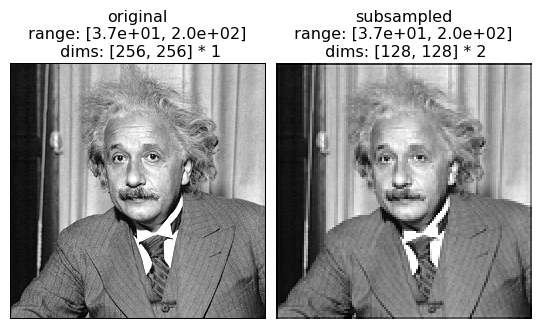

In [4]:
# imshow: 3 types of automatic graylevel scaling,
# 2 types of automatic sizing, with or without title and Range information.
# to see the documentation for a function, run:`? pt.imshow`

pt.imshow([oim,im], title=['original', 'subsampled'], vrange='auto2', col_wrap=2);

## Statistics:

In [5]:
pt.image_stats(im);

Image statistics:
  Range: [10.126404, 245.754672]
  Mean: 116.771655,  Stdev: 37.977892,  Kurtosis: 3.085949


## Synthetic images

In [6]:
# pick some parameters
size      = 256
direction = 2 * np.pi * np.random.rand(1)
slope     = 10 * np.random.rand(1) - 5
intercept = 10 * np.random.rand(1) - 5
origin    = np.round(size * np.random.rand(2,1)).astype(int)
exponent  = 0.8 + np.random.rand(1)
amplitude = 1 + 5 * np.random.rand(1)
phase     = 2 * np.pi * np.random.rand(1)
period    = 20
twidth    = 7

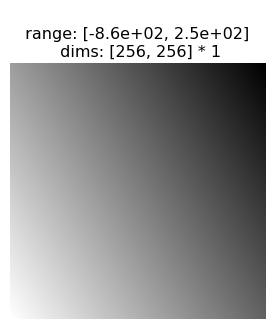

In [7]:
pt.imshow(pt.synthetic_images.ramp(size, direction, slope, intercept, origin));

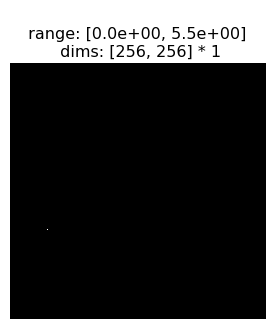

In [8]:
pt.imshow(pt.synthetic_images.impulse(size, origin, amplitude));

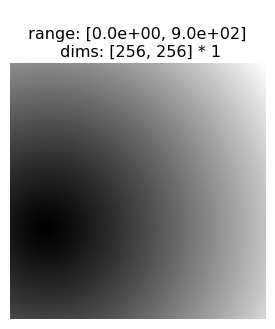

In [9]:
pt.imshow(pt.synthetic_images.polar_radius(size, exponent, origin));

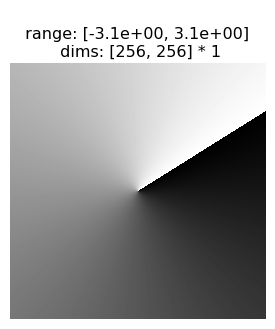

In [10]:
pt.imshow(pt.synthetic_images.polar_angle(size, direction));

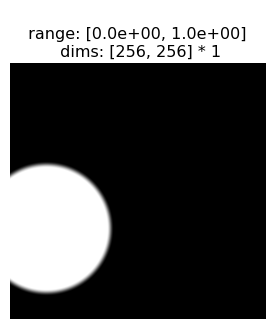

In [11]:
pt.imshow(pt.synthetic_images.disk(size, size/4, origin, twidth));

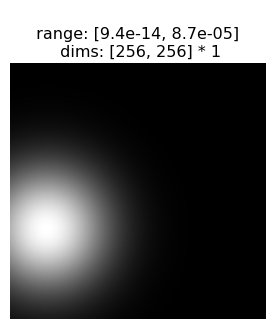

In [12]:
pt.imshow(pt.synthetic_images.gaussian(size, (size/6)**2, origin, 'norm'));

In [13]:
# TODO fix normalization - range
g = pt.synthetic_images.gaussian(size, (size/6)**2, origin, 'norm')
g.min(), g.max()

(9.402979666533684e-14, 8.742642137616321e-05)

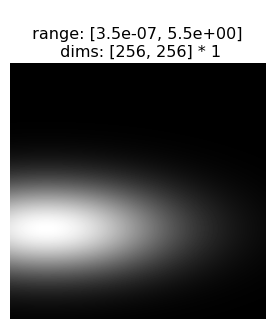

In [14]:
pt.imshow(pt.synthetic_images.gaussian(size, ((size/8)**2,(size/3)**2), origin, amplitude));

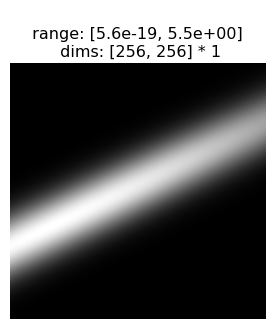

In [15]:
# cov = (size * np.random.uniform(-1,1,(2,2)))
# cov = cov.dot(cov.T)
# print(np.round(cov))
cov = np.array((( 12571., -25233.),
                (-25233.,  52488.)))

pt.imshow(pt.synthetic_images.gaussian(size, cov, origin, amplitude));

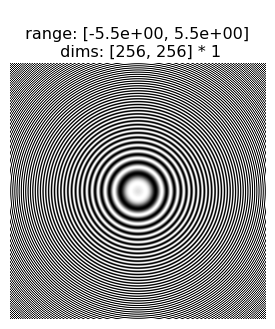

In [16]:
fig=pt.imshow(pt.synthetic_images.zone_plate(size, amplitude, phase));
fig.savefig('zoneplate.png')

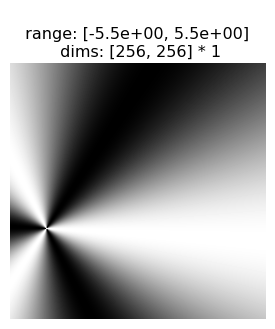

In [17]:
pt.imshow(pt.synthetic_images.angular_sine(size, 3, amplitude, phase, origin));

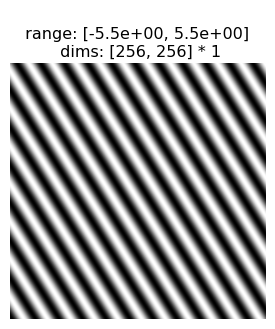

In [18]:
pt.imshow(pt.synthetic_images.sine(size, period, direction, amplitude=amplitude, phase=phase, origin=origin));

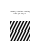

In [19]:
pt.imshow(pt.synthetic_images.sine(20, frequency=[1,2]));

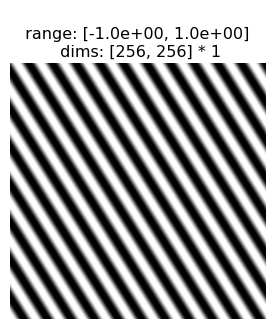

In [20]:
pt.imshow(pt.synthetic_images.square_wave(size, period, direction, amplitude, phase=phase, origin=origin, twidth=twidth));

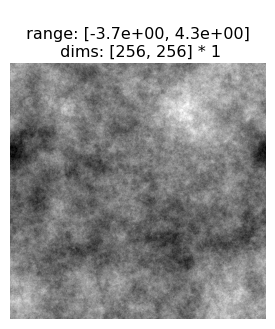

In [21]:
pt.imshow(pt.synthetic_images.pink_noise(size, exponent));

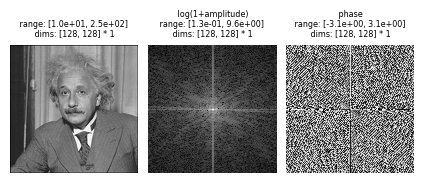

In [22]:
# Plotting complex valued images

sp = np.fft.fftshift(np.fft.fft2(im, norm='ortho'))

pt.imshow([im, sp], plot_complex='logpolar');

## Point operations (lookup tables):

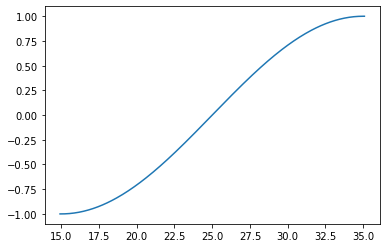

In [23]:
Xtbl,Ytbl = pt.rcosFn(width=20, position=25, values=(-1, 1))
plt.plot(Xtbl,Ytbl)
plt.show()

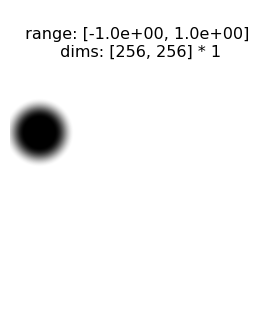

In [24]:
pt.imshow(pt.pointOp(pt.synthetic_images.polar_radius(size,1,[70,30]), Ytbl, Xtbl[0], Xtbl[1]-Xtbl[0], 0));

## Convolution routines: Compare speed of convolution/downsampling routines

In [25]:
k = 5
size = 2 ** 9
noise = np.random.rand(size,size)
filt  = np.random.rand(k,k)

In [26]:
%%time
res1 = pt.corrDn(noise, np.flipud(np.fliplr(filt)), 'reflect1', step=[2, 2])

CPU times: user 4.54 ms, sys: 8.26 ms, total: 12.8 ms
Wall time: 4.15 ms


In [27]:
%%time
ires = pt.rconv2(noise,filt) # this is using scipy.signal.convolve
res2 = ires[0:size:2,0:size:2]

CPU times: user 48.9 ms, sys: 18.1 ms, total: 67 ms
Wall time: 22.3 ms


In [28]:
res1 = pt.corrDn(noise, np.flipud(np.fliplr(filt)), 'reflect1', step=[2, 2])
ires = pt.rconv2(noise,filt) # this is using scipy.signal.convolve
res2 = ires[0:size:2,0:size:2]
pt.image_compare(res1, res2);

Difference statistics:
  Range: [0, 0]
  Mean: -0.000000,  Stdev (rmse): 0.000000,  SNR (dB): 294.068252


In [29]:
res3 = pt.corrDn(noise, np.flipud(np.fliplr(filt)), 'reflect1', step=[1, 1])
pt.image_compare(res3, ires);

Difference statistics:
  Range: [0, 0]
  Mean: -0.000000,  Stdev (rmse): 0.000000,  SNR (dB): 294.006866


In [30]:
im = plt.imread('../DATA/Einstein.pgm').astype(float)
# im = pt.synthetic_images.impulse(256, origin=None)

In [31]:
binom5 = pt.binomial_filter(5)
# construct a separable 2D filter
lo_filt = 2*binom5*binom5.T   

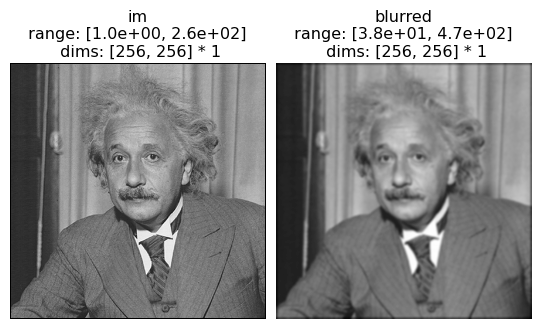

In [32]:
blurred = pt.rconv2(im, lo_filt) 
pt.imshow([im, blurred], title=['im', 'blurred']);

In [33]:
# much faster implementation:
b = pt.corrDn(im, np.flipud(np.fliplr(lo_filt)), 'reflect1', step=[1, 1])
pt.image_compare(blurred, b);

# each dimension separately
bx  = pt.corrDn(im, binom5.T, 'reflect1')
bxy = pt.corrDn(bx, binom5, 'reflect1')
bxy *= 2
pt.image_compare(bxy, b);

Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): 305.282881
Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): inf


Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): inf


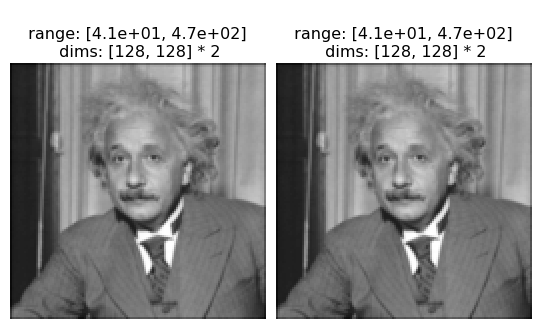

In [34]:
# blur and downsample in a single step
blurred1 = pt.corrDn(image = im, filt = lo_filt, step = (2,2))

bx  = pt.corrDn(im, binom5.T, 'reflect1', step=[1, 2])
bxy = pt.corrDn(bx, binom5, 'reflect1', step=[2, 1])
bxy *= 2

pt.imshow([blurred1, bxy], zoom=2);
pt.image_compare(blurred1, bxy);

In [35]:
# NOTE: here is helper to decide on subsampling depending on machine speed

import time
t = time.time()
pt.corrDn(oim, filt=np.ones((2,2)) / 4, edge_type='reflect1', step=(2, 2), start=(0, 0), stop=None)
elapsed = time.time() - t
imSubSample = min(max(np.floor(np.log2(elapsed)/2+3),0),2)
imSubSample

0

## Handling of left and top boundaries:

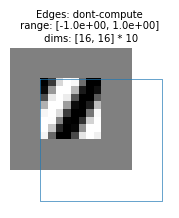

In [36]:
fsz = [9, 9]
fmid = np.ceil((fsz[0]+1)/2)
imsz = (16, 16)

# pick one:
im = np.eye(imsz[0])
im = pt.synthetic_images.ramp(imsz, np.pi/6)
im = pt.synthetic_images.square_wave(imsz, 6, np.pi/6)

# pick one:
edges='reflect1'
edges='reflect2'
edges='repeat'
edges='extend'
edges='zero'
edges='circular'
edges='dont-compute'

filt = pt.synthetic_images.impulse(fsz,[0, 0])
pt.imshow(pt.corrDn(im,filt,edges), zoom=10, title='Edges: ' + str(edges))
# TODO
plt.plot([0,0,imsz[1],imsz[1],0]+fmid-1.5,
         [0,imsz[0],imsz[0],0,0]+fmid-1.5, lw=.5)
plt.show()